# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

Шаг 1

Подключим необходимые для работы библиотеки

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams, rcParamsDefault

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Откроем файл с данными и изучим общую информацию

In [3]:
df = pd.read_csv('/datasets/users_behavior.csv')
display(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


None

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [5]:
df.isna().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

In [6]:
df.duplicated().sum()

0

Всего датасет содержит 3214 строк и 5 столбцов, из которых 1 имеет целочисленный тип данных, а в остальных 4-ех столбцах данные представлены вещественными числами. 
В датасете нету пропусков и дубликатов. 

**Названия столбцов датасета**

* сalls — количество звонков;
* minutes — суммарная длительность звонков в минутах;
* messages — количество sms-сообщений;
* mb_used — израсходованный интернет-трафик в Мб;
* is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Разбейте данные на выборки

In [7]:
# Разбил датасет на 3 выборки: обучающую, валидационную, тестовую
df_train, df_test = train_test_split(df, test_size=0.4, random_state=12345, stratify=df.is_ultra)
df_valid, df_valid_test = train_test_split(df_test, test_size=0.5, random_state=12345, stratify=df_test.is_ultra)

print(df_train.shape)
print(df_valid.shape)
print(df_valid_test.shape)

(1928, 5)
(643, 5)
(643, 5)


Получилось три датасета(Размеры тестового и валидационного набора обычна равны, поэтому исходные данные разбил в соотношение 3:1:1):
* df_train - содержит обучающую выборку(нужна для обучения модели)
* df_valid - содержит валидационную выборку(нужна для проверки модели на переобучение или недообучение)
* df_valid_test - содержит тестовую выборку(понадобится для оценки качества модели)

## Исследуйте модели

Целевым признаком у нас является столбец 'is_ultra', т.к. у нас задача предложить пользователям новый тариф: «Смарт» или «Ультра». Следовательно этот признак является категориальным, то значит мы будем решать задачу классификации, а если быть точнее у нас категорий всего две, значит речь идёт о бинарной(двоичной) классификации.

Мы исследуем качество трёх моделей:
* Решающее дерево
* Случайный лес
* Логистическая регрессия

Каждую модель обучим на обучающем наборе и проверим на валидационной выборке,чтобы определить лучшую модель.
Так как наборы данных для всех моделей у нас одинаковые, объявим для каждой модели переменные features и target (признаки и целевой признак), которым присвоим соответствующие им признаки.

In [8]:
features_train = df_train.drop(['is_ultra'], axis=1)
target_train = df_train['is_ultra']

features_valid = df_valid.drop(['is_ultra'], axis=1)
target_valid = df_valid['is_ultra']

features_test = df_test.drop(['is_ultra'], axis=1)
target_test = df_test['is_ultra']

**Модель: Решающее дерево**

[0.7403, 0.7729, 0.7776, 0.7543, 0.7854, 0.7745, 0.7869, 0.8025, 0.7823, 0.7729]
Максимальная доля правильных ответов: 0.8025 при глубине дерева: 8


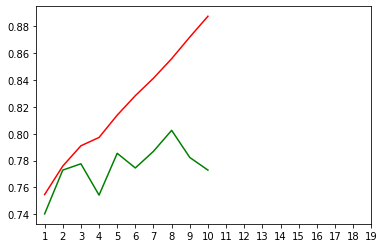

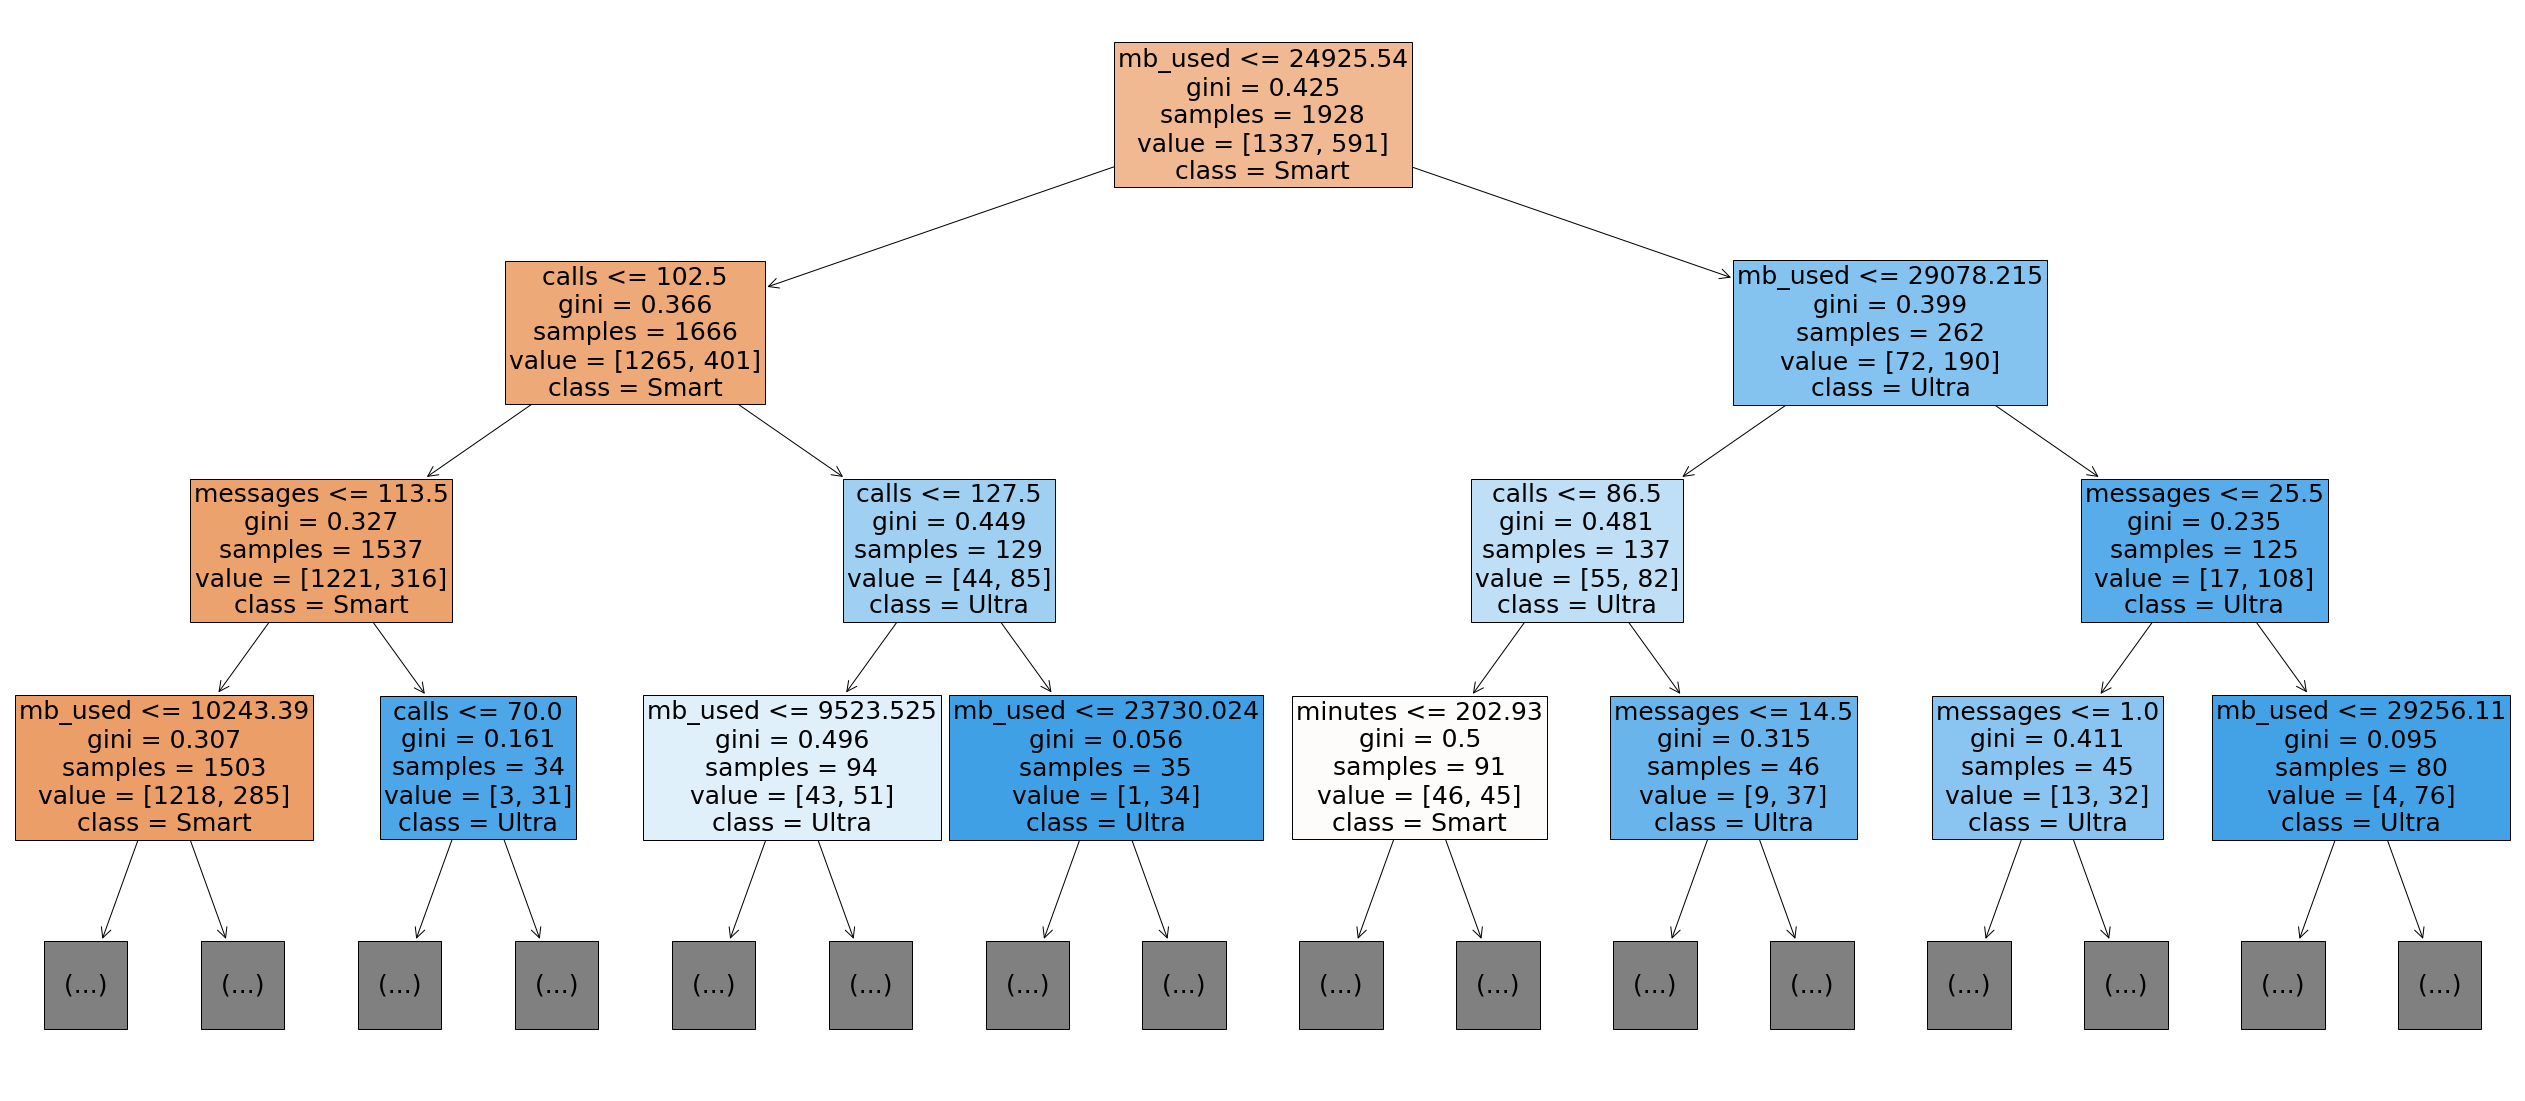

In [9]:
from sklearn.tree import plot_tree

accuracy_tree_list = []
accuracy_tree_list2 = []
all_depth = []
score_model = pd.DataFrame()
best_model_tree = None
best_depth_tree = 0
best_tree = 0
for depth in range(1, 11):
    model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth) # инициализируйте модель DecisionTreeClassifier с параметром random_state=12345 и max_depth=depth
    model_tree.fit(features_train, target_train) # обучил модель на тренировочной выборке
    predictions_tree = model_tree.predict(features_valid) # получил предсказания модели
    predictions_tree_train = model_tree.predict(features_train)
    accuracy_tree = round(accuracy_score(target_valid, predictions_tree), 4) #выявил долю правильных ответов
    accuracy_tree_train = round(accuracy_score(target_train, predictions_tree_train), 4)
    accuracy_tree_list.append(accuracy_tree)
    accuracy_tree_list2.append(accuracy_tree_train)
    if accuracy_tree > best_tree:
                best_tree = accuracy_tree
                best_model_tree = model_tree
                best_depth_tree = depth
    all_depth.append(depth)
print(accuracy_tree_list)
print('Максимальная доля правильных ответов:', max(accuracy_tree_list), 'при глубине дерева:', np.argmax(accuracy_tree_list)+1)

#plot_tree(model_tree, max_depth=4)

sns.lineplot(x=all_depth, y=accuracy_tree_list, color='g')
sns.lineplot(x=all_depth, y=accuracy_tree_list2, color='r')
plt.xticks(list(range(1, 20)))

fig = plt.figure(figsize=(45,20))
#fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(45, 20))
plot_tree(model_tree, 
               feature_names=features_valid.columns.values, 
               class_names=['Smart','Ultra'],
               filled=True,
               fontsize = 25,
               max_depth=3)

plt.show()


Лучший вариант модели решающего дерева равен при глубине 3 процент правильных ответов = 78%. 

**Модель: Случайный лес**

In [10]:
%%time

from tqdm import tqdm

best_model = None
best_est = 0
best_depth = 0
best_forest = 0
best_sample_leaf = 0
for est in tqdm(range(10, 51, 10)):
    for depth in range (1, 11):
        for sample in range(1, 11):
            model_forest = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=est, min_samples_leaf=sample) # инициализировал модель RandomForestClassifier с параметрами random_state=12345, n_estimators=est и max_depth=depth
            model_forest.fit(features_train, target_train) # обучил модель на тренировочной выборке
            predictions_forest = model_forest.predict(features_valid) # получил предсказания модели
            accuracy_forest = round(accuracy_score(target_valid, predictions_forest), 4) #выявил долю правильных ответов
            if accuracy_forest > best_forest:
                best_forest = accuracy_forest
                best_model = model_forest
                best_est = est
                best_depth = depth
                best_sample_leaf = sample
print(f'Максимальная доля правильных ответов: {best_forest} при глубине дерева {depth}, количестве деревьев {est} и объектов в листьях дерева {best_sample_leaf}')

100%|██████████| 5/5 [00:37<00:00,  7.52s/it]

Максимальная доля правильных ответов: 0.8227 при глубине дерева 10, количестве деревьев 50 и объектов в листьях дерева 8
CPU times: user 37.4 s, sys: 224 ms, total: 37.6 s
Wall time: 37.6 s


Лучший вариант модели случайного леса равен при глубине 10, количестве деревьев 50 и количестве объектов в листьях дерева 1 в нем процент правильных ответов = 80%. 

**Модель: Логистическая регрессия**

In [11]:
model_logic = LogisticRegression(random_state=12345, solver='lbfgs')
model_logic.fit(features_train, target_train)

predictions_logic = model_logic.predict(features_valid)

accuracy_logic = round(accuracy_score(target_valid, predictions_logic), 4)
print(f'Максимальная доля правильных ответов: {accuracy_logic}')

Максимальная доля правильных ответов: 0.7387


Процент правильных ответов у модели логистической регрессии = 71%.

**Вывод по трем моделям:**
* Качество модели "Дерево предсказания" при гиперпараметрах max_depth = 3: 0.78
* Качество модели "Случайный лес" при гиперпараметрах max_depth = 10, n_estimators = 50 и min_samples_leaf = 1: 0.80
* Качество модели "Логистическая регрессия": 0.71

**Лучшей моделью получилась - модель "Случайный лес"**, а худший результат показала модель логистической регрессии.

## Проверьте модель на тестовой выборке

Проверил качество лучшей модели на тестовой выборке

In [12]:
predictions_forest_test = model_forest.predict(features_test)
accuracy_forest_test = round(accuracy_score(target_test, predictions_forest_test), 4)
print(f'test_accuracy: {accuracy_forest_test}')

test_accuracy: 0.8196


Качество модели 'Случайный лес' на тестовой выборке равна почти 80%.

**Качество модели на тестовой выборке == Качеству модели на валидационной выборке**

## (бонус) Проверьте модели на адекватность

In [13]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy='most_frequent', random_state=1)
dummy.fit(features_train, target_train)
dummy.predict(features_test)
dummy.score(features_test, target_test)

0.6936236391912908

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75


##  Вывод

Рассмотрев и проанализировав три модели: "Решающее дерево", "Случайный лес" и "Логистическая регрессия". Я выявил, что лучшая модель, которая паказала 80% правильных ответов это модель 'Случайный лес', поэтому в последующих задачах я использовал её.  Оценив ещё её качество на тестовом наборе данных, который показал тоже 80% правильных ответов, я сделал вывод, что моя модель подходит для задачи заказчика. Следовательно её уже можно использовать для предложения клиентам заказчика нового тарифа "Смарт" или "Ультра".


<div class="alert alert-info">
<font size="5"><b>Комментарий ревьюера</b></font>




Дмитрий, у тебя старательно выполненная работа, все четко, осмысленно. Выводы присутствуют, с комментированием кода тоже никаких проблем нет, твоих объяснений достаточно для понимания коллегами хода твоих мыслей.  Вижу у тебя получается в ML,  дальше будет интересней )  



Я оставил небольшие советы и вопросики (если есть время и желание можешь воспользоваться/ответить): 




- обрати внимание на проверку сбалансированность классов в таргете в разделе EDA
- использовать stratify
- добавить график метрики    
- посоветовал посмотреть в сторону GridSearchCV
- как можно улучшить результаты 



Замечания на будущее:
    

 
- Было бы замечательно, в выводе немножко о данных, работе с ними (пусть даже никакой работы и не было). Это важно потому что когда проект захочет посмотреть будущий работодатель (или начальник), у него может не быть времени на подробный разбор кода. Вероятнее всего он бегло просмотрит код, а из общего вывода захочет получить представление о всей работе.

 
    

Посылаю на вторую итерацию, чтобы посмотреть твое решение бонусного задания(если будешь делать) и ответить на вопросы если они появятся


</div>


<div class="alert alert-info">
<font size="5"><b>Комментарий ревьюераV2</b></font>

Дмитрий после первой итерации ошибок у тебя не было, а вот сейчас возникли )

Это не исполнение кода - стоит поправить

На связи



</div>


<div class="alert alert-info">
<font size="5"><b>Комментарий ревьюераV3</b></font>

Спасибо за работу!    

    
Красное исправлено, многие желтые советы использованы, на  вопросы есть ответы  (это все было по желанию), значит стремишься развиваться, а желание и интерес это главное. Надеюсь мои советы и вопросики были полезны и в копилочку знаний упало что то новое, а проект стал лучше, и симпатичней.



  
Отличная работа Дмитрий. Желаю успехов в дальнейшей учебе!





</div>